# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Palatino Linotype"
plt.rcParams["font.size"] = 12


# Constants

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=False, processed=False, enhanced=True)

Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


In [5]:
def add_info(dataframe: pd.DataFrame) -> pd.DataFrame:
    historic_steps = {
        "duration_incident_creation": ("time_call_received", "time_incident_created"),
        "duration_resource_appointment": ("time_incident_created", "time_resource_appointed"),
        "duration_resource_preparing_departure": ("time_resource_appointed", "time_ambulance_dispatch_to_scene"),
        "duration_dispatching_to_scene": ("time_ambulance_dispatch_to_scene", "time_ambulance_arrived_at_scene"),
        "duration_at_scene": ("time_ambulance_arrived_at_scene", "time_ambulance_dispatch_to_hospital", "time_ambulance_available"),
        "duration_dispatching_to_hospital": ("time_ambulance_dispatch_to_hospital", "time_ambulance_arrived_at_hospital"),
        "duration_at_hospital": ("time_ambulance_arrived_at_hospital", "time_ambulance_available")
    }

    for step, times in historic_steps.items():
        if len(times) == 3:
            dataframe.loc[dataframe[times[1]].isna(), step] = (dataframe[times[2]] - dataframe[times[0]]).dt.total_seconds()
            dataframe.loc[~dataframe[times[1]].isna(), step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds()
        else:
            dataframe[step] = (dataframe[times[1]] - dataframe[times[0]]).dt.total_seconds() / 60
    
    response_time_cols = [
        'duration_incident_creation',
        'duration_resource_appointment',
        'duration_resource_preparing_departure',
        'duration_dispatching_to_scene'
    ]
    dataframe['total_response_time'] = dataframe[response_time_cols].sum(axis=1)

    return dataframe

In [6]:
df = add_info(data_loader.enhanced_incidents_df.copy(True))

avg_response_time_by_hour = df.groupby(df['time_call_received'].dt.hour)['total_response_time'].mean()
response_time_by_hour_triage = df.groupby([df['time_call_received'].dt.hour, 'triage_impression_during_call'])['total_response_time'].mean().unstack()


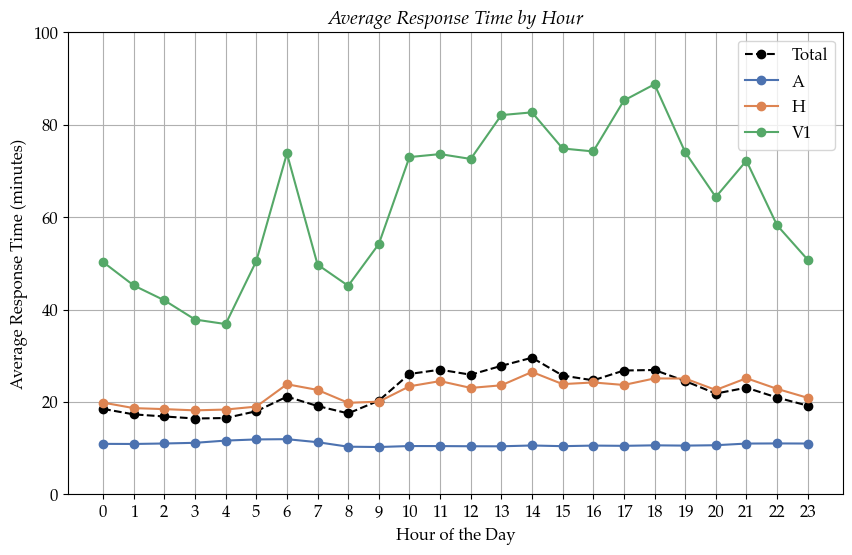

In [11]:
# Define seaborn color map for clarity
sns_color_map = {
    "A": sns.color_palette("deep")[0],  # Seaborn's default blue
    "H": sns.color_palette("deep")[1],  # Seaborn's default orange
    "V1": sns.color_palette("deep")[2],  # Seaborn's default green
    "Total": "black"  # Keeping 'Total' in black for distinction
}

plt.figure(figsize=(10, 6))

# Plot the overall average response time with a distinct color
plt.plot(avg_response_time_by_hour.index, avg_response_time_by_hour.values, marker='o', linestyle='--', color=sns_color_map["Total"], label='Total')

# Plot the average response time by triage impression with specific seaborn colors
for triage, data in response_time_by_hour_triage.items():
    if triage in sns_color_map:  # Ensure we have a color defined for the triage from seaborn palette
        plt.plot(data.index, data.values, marker='o', linestyle='-', color=sns_color_map[triage], label=triage)

plt.xlabel('Hour of the Day')
plt.ylabel('Average Response Time (minutes)')
title = 'Average Response Time by Hour'
plt.title(title, fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
plt.xticks(range(24))
plt.legend(loc="upper right")
plt.grid(True)
plt.ylim(0, 100)
plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title + ".png"), dpi=300, bbox_inches='tight')
plt.show()


In [13]:
df = add_info(data_loader.enhanced_incidents_df.copy(True))

avg_response_time_by_hour = df.groupby(df['time_call_received'].dt.hour)['duration_dispatching_to_scene'].mean()
response_time_by_hour_triage = df.groupby([df['time_call_received'].dt.hour, 'triage_impression_during_call'])['duration_dispatching_to_scene'].mean().unstack()


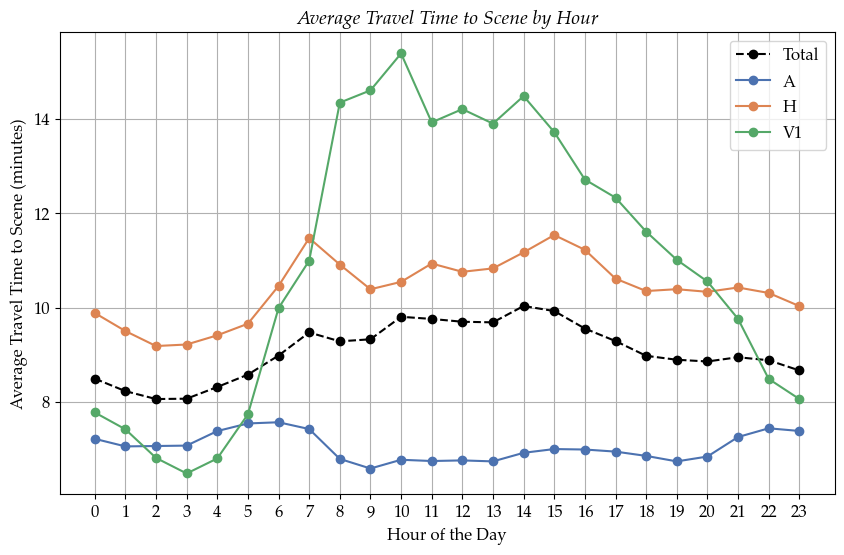

In [15]:
# Define seaborn color map for clarity
sns_color_map = {
    "A": sns.color_palette("deep")[0],  # Seaborn's default blue
    "H": sns.color_palette("deep")[1],  # Seaborn's default orange
    "V1": sns.color_palette("deep")[2],  # Seaborn's default green
    "Total": "black"  # Keeping 'Total' in black for distinction
}

plt.figure(figsize=(10, 6))

# Plot the overall average response time with a distinct color
plt.plot(avg_response_time_by_hour.index, avg_response_time_by_hour.values, marker='o', linestyle='--', color=sns_color_map["Total"], label='Total')

# Plot the average response time by triage impression with specific seaborn colors
for triage, data in response_time_by_hour_triage.items():
    if triage in sns_color_map:  # Ensure we have a color defined for the triage from seaborn palette
        plt.plot(data.index, data.values, marker='o', linestyle='-', color=sns_color_map[triage], label=triage)

plt.xlabel('Hour of the Day')
plt.ylabel('Average Travel Time to Scene (minutes)')
title = 'Average Travel Time to Scene by Hour'
plt.title(title, fontdict=constants.FONT_PROPERTIES_SUB_HEADER)
plt.xticks(range(24))
plt.legend(loc="upper right")
plt.grid(True)
plt.savefig(os.path.join(constants.PROJECT_DIRECTORY_PATH, "source", "analysis", "plots", title + ".png"), dpi=300, bbox_inches='tight')
plt.show()
